## Welcome! 
The purpose of this notebook is to familiarise yourself with our dataset, Biopython, and rdKit. 

Notebook ML_DL_GNN contains tutorials and examples of how to create and train machine learning, neural networks and graph neural network models. 



In [52]:
# import libraries that we will use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch 
import Bio
import rdkit

In [ ]:
# this tells us where we are working

os.getcwd()

'c:\\Users\\sjobe\\OneDrive - Uppsala universitet\\year_5\\PhD\\End_Course_Molecular_BioPhysics\\.git\\PPI_Project_HT_2025\\code\\example'

In [54]:
## Lets start looking at some availible data. 
# in data/example we have the whole dataset from PPB-Affinity

df = pd.read_excel('../../data/example/PPB-Affinity.xlsx')
df.head()

,Unnamed: 0,Source Data Set,Complex ID,PDB,Mutations,Ligand Chains,Receptor Chains,Ligand Name,Receptor Name,KD(M),Affinity Method,Structure Method,Temperature(K),Resolution(Å),PDB PubMed ID,PDB Release Date,Affinity PubMed ID,Affinity Release Date,Subgroup
0,0,SKEMPI v2.0,"1A22:A, B::PMID=7504735",1A22,NaN,A,B,Human growth hormone,hGH binding protein,9.000000e-10,SPR,X-RAY DIFFRACTION,298,2.60,9571026.0,1998-04-29,7504735,1993 Dec 5,NaN
1,1,SKEMPI v2.0,"1A4Y:A, B::PMID=9050852",1A4Y,NaN,A,B,Ribonuclease inhibitor,Angiogenin,5.000000e-16,Other,X-RAY DIFFRACTION,298,2.00,9311977.0,1998-10-14,9050852,1997 Mar 4,NaN
2,2,SKEMPI v2.0,"1ACB:E, I::PMID=9048543",1ACB,NaN,E,I,Bovine alpha-chymotrypsin,Eglin c,1.490000e-12,IASP,X-RAY DIFFRACTION,294,2.00,1583684.0,1993-10-31,9048543,1997 Feb 18,NaN
3,3,SKEMPI v2.0,"1AHW:A, B, C::PMID=9480775",1AHW,NaN,"A, B",C,Immunoglobulin fab 5G9,Tissue factor,3.400000e-09,IASP,X-RAY DIFFRACTION,298(assumed),3.00,9480775.0,1998-02-25,9480775,1998 Feb 6,NaN
4,4,SKEMPI v2.0,"1AK4:A, D::PMID=9223641",1AK4,NaN,A,D,Cyclophilin A,HIV-1 capsid protein,1.200000e-05,SPR,X-RAY DIFFRACTION,298(assumed),2.36,8980234.0,1997-10-15,9223641,1997 Jun 27,NaN


This file has a lot of information, lets focus what is most important. Four our purposes we want to focus on 'PDB', 'Source Data Set', 'Mutations', 'Ligand Chains', 'Receptor Chains',
                                        'KD(M)', 'Subgroup'. 
We also want to add a column of dG so convert the column using the formula dG = -RTln(KD)


In [55]:
## code to add dG column here

### answer:


df['dg']=(8.314/4184)*(273.15 + 25.0) * np.log(df['KD(M)'])

In [56]:
df['dg']=(8.314/4184)*(273.15 + 25.0) * np.log(df['KD(M)'])

### Lets continue and explore our data a bit more, so lets plot the distribution of dg values

count    12062.000000
mean       -10.287966
std          2.924959
min        -21.416081
25%        -12.301725
50%        -10.370511
75%         -8.012743
max         -1.799013
Name: dg, dtype: float64

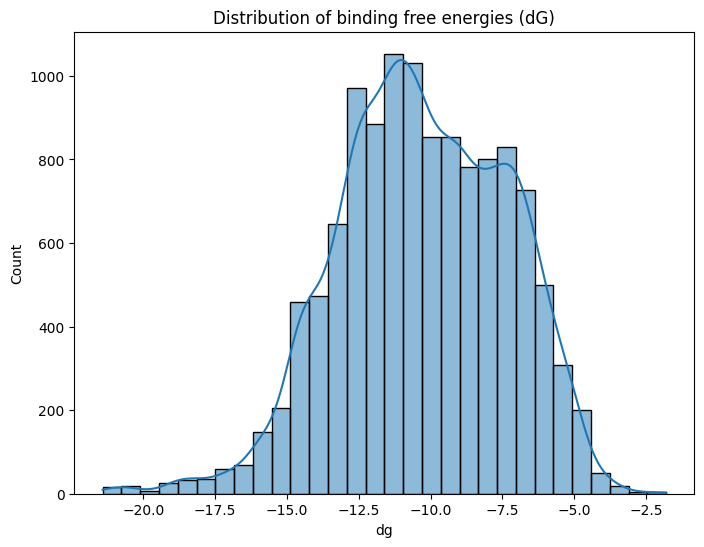

In [57]:
plt.figure(figsize=(8,6))
sns.histplot(df['dg'], bins=30, kde=True)
plt.title('Distribution of binding free energies (dG)')
#we can also look at some statistics of the distribution
df['dg'].describe()

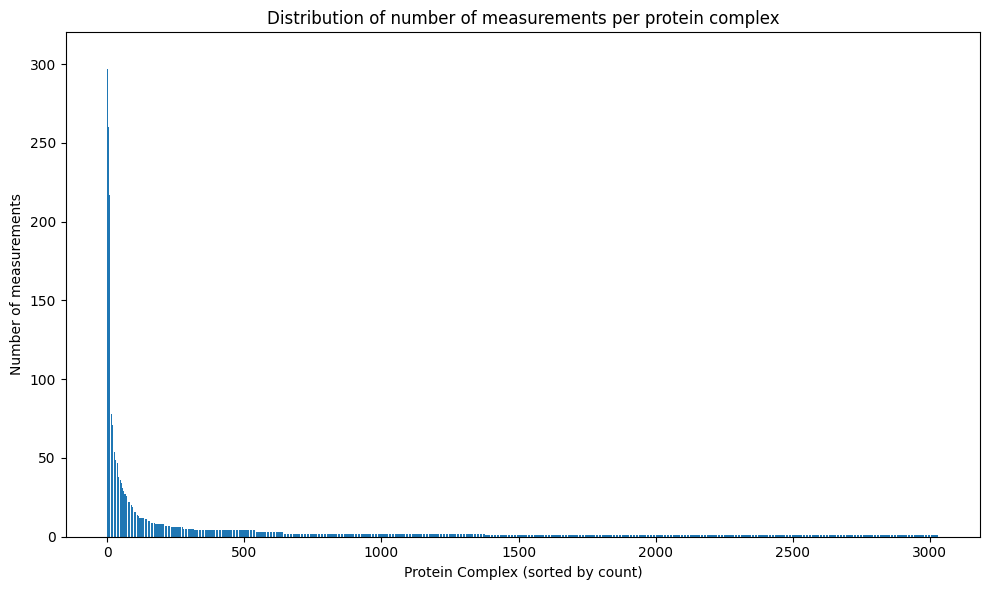

count    3032.000000
mean        3.978232
std        16.407952
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       305.000000
Name: count, dtype: float64


In [ ]:
# let us also inspect the distribution of measurements per protein complex
complex_counts = df['PDB'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(range(len(complex_counts)), complex_counts.values)
plt.ylabel('Number of measurements')
plt.title('Distribution of number of measurements per protein complex')
plt.tight_layout()
plt.show()

# Show summary statistics
print(complex_counts.describe())


In [92]:
# we can see that most complexes have few measurements, but some have quite alot.
# lets inspect the one with most measurements
most_measured_pdb = complex_counts.idxmax()
print(f'The most measured PDB is {most_measured_pdb} with {complex_counts.max()} measurements.')

most_measured_df = df[df['PDB'] == most_measured_pdb]

The most measured PDB is 1AO7 with 305 measurements.


In [93]:
most_measured_df

,Unnamed: 0,Source Data Set,Complex ID,PDB,Mutations,Ligand Chains,Receptor Chains,Ligand Name,Receptor Name,KD(M),Affinity Method,Structure Method,Temperature(K),Resolution(Å),PDB PubMed ID,PDB Release Date,Affinity PubMed ID,Affinity Release Date,Subgroup,dg
5,5,SKEMPI v2.0,"1AO7:A, B, C, D, E::PMID=23736024",1AO7,NaN,"A, B, C","D, E",HLA-A2 plus tax peptide,A6 TCR,3.640000e-06,SPR,X-RAY DIFFRACTION,298,2.6,8906788.0,1997-09-17,23736024,2013,TCR-pMHC,-7.419588
3690,3932,SKEMPI v2.0,"1AO7:A, B, C, D, E:D_D26A:PMID=23736024",1AO7,D_D26A,"A, B, C","D, E",HLA-A2 plus tax peptide,A6 TCR,1.900000e-05,SPR,X-RAY DIFFRACTION,298,2.6,8906788.0,1997-09-17,23736024,2013,TCR-pMHC,-6.440588
3691,3933,SKEMPI v2.0,"1AO7:A, B, C, D, E:A_E58A:PMID=23736024",1AO7,A_E58A,"A, B, C","D, E",HLA-A2 plus tax peptide,A6 TCR,1.080000e-06,SPR,X-RAY DIFFRACTION,298,2.6,8906788.0,1997-09-17,23736024,2013,TCR-pMHC,-8.139431
3692,3934,SKEMPI v2.0,"1AO7:A, B, C, D, E:A_E58A, D_D26A:PMID=23736024",1AO7,"A_E58A, D_D26A","A, B, C","D, E",HLA-A2 plus tax peptide,A6 TCR,1.290000e-05,SPR,X-RAY DIFFRACTION,298,2.6,8906788.0,1997-09-17,23736024,2013,TCR-pMHC,-6.669992
3693,3935,SKEMPI v2.0,"1AO7:A, B, C, D, E:D_R27A:PMID=23736024",1AO7,D_R27A,"A, B, C","D, E",HLA-A2 plus tax peptide,A6 TCR,4.880000e-06,SPR,X-RAY DIFFRACTION,298,2.6,8906788.0,1997-09-17,23736024,2013,TCR-pMHC,-7.245904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11664,12607,ATLAS,"1AO7:A, C, D, E:E_E105H, E_Q106P, E_Y107Q:PMID...",1AO7,"E_E105H, E_Q106P, E_Y107Q","A, C","D, E",LLFGYPVYV-HLA-A*02:01,A6,1.500000e-06,SPR,X-RAY DIFFRACTION,298.15,2.6,8906788.0,1997-09-17,15723046,2005-03-01,TCR-pMHC,-7.944808
11665,12608,ATLAS,"1AO7:A, C, D, E:E_A99M, E_G100S, E_G101A, E_R1...",1AO7,"E_A99M, E_G100S, E_G101A, E_R102Q","A, C","D, E",LLFGYPVYV-HLA-A*02:01,A6,2.500000e-09,SPR,X-RAY DIFFRACTION,298.15,2.6,8906788.0,1997-09-17,15723046,2005-03-01,TCR-pMHC,-11.734682
11666,12609,ATLAS,"1AO7:A, C, D, E:A_K66A:PMID=16197958",1AO7,A_K66A,"A, C","D, E",LLFGYPVYV-HLA-A*02:01,A6,2.000000e-04,SPR,X-RAY DIFFRACTION,298.15,2.6,8906788.0,1997-09-17,16197958,2005-10-28,TCR-pMHC,-5.046028
11667,12610,ATLAS,"1AO7:A, C, D, E:C_Y5F:PMID=15670602",1AO7,C_Y5F,"A, C","D, E",LLFGFPVYV-HLA-A*02:01,A6,2.700000e-06,SPR,X-RAY DIFFRACTION,298.15,2.6,8906788.0,1997-09-17,15670602,2005-02-18,TCR-pMHC,-7.596573


array([[<Axes: title={'center': 'dg'}>]], dtype=object)

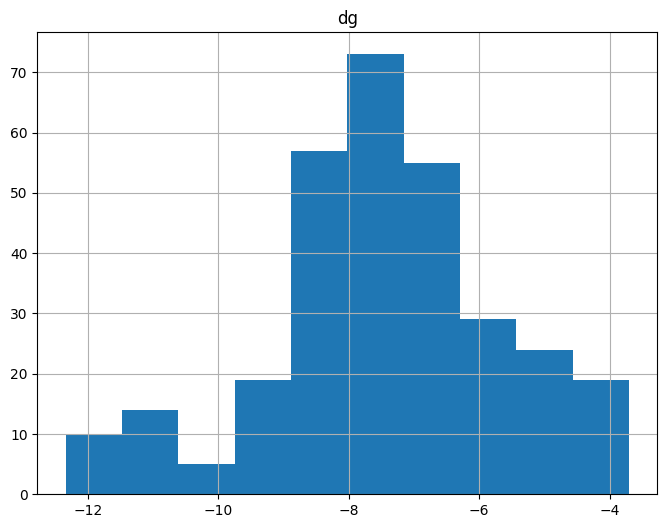

In [96]:
most_measured_df.hist(column='dg', bins=10, figsize=(8,6))

We see that the most measured one is 1AO7, which from the PDB is C-SRC (SH2 DOMAIN) COMPLEXED WITH ACE-MALONYL TYR-GLU-(N,N-DIPENTYL AMINE). 

## Moving on to Biopython
Lets look at the first row in our dataset 


In [39]:
example_row = df.iloc[0]
pdb_id = example_row['PDB']

print(f"PDB ID: {pdb_id}")

PDB ID: 1A22


In [40]:
from Bio.PDB import PDBParser

pdb_parser = PDBParser()
structure = pdb_parser.get_structure(pdb_id, f'../../data/example/{pdb_id}.pdb')

c:\Users\sjobe\OneDrive - Uppsala universitet\Farma\pharmpygui\Lib\site-packages\Bio\PDB\PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1467
  warnings.warn(
c:\Users\sjobe\OneDrive - Uppsala universitet\Farma\pharmpygui\Lib\site-packages\Bio\PDB\PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3046
  warnings.warn(
c:\Users\sjobe\OneDrive - Uppsala universitet\Farma\pharmpygui\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3047.
  warnings.warn(
c:\Users\sjobe\OneDrive - Uppsala universitet\Farma\pharmpygui\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3073.
  warnings.warn(


In [44]:
for chain in structure.get_chains():
    print(f"Chain ID: {chain.id}")
    for i, residue in enumerate(chain.get_residues()):
        if i < 10:
            print(f"Residue: {residue.get_resname()} {residue.id[1]}")
        else:
            break

Chain ID: A
Residue: PHE 1
Residue: PRO 2
Residue: THR 3
Residue: ILE 4
Residue: PRO 5
Residue: LEU 6
Residue: SER 7
Residue: ARG 8
Residue: LEU 9
Residue: PHE 10
Chain ID: B
Residue: PRO 1
Residue: LYS 2
Residue: PHE 3
Residue: THR 4
Residue: LYS 5
Residue: CYS 6
Residue: ARG 7
Residue: SER 8
Residue: PRO 9
Residue: GLU 10


Two interacting chains (A and B)

Now lets see what we can do with a specific residue pair

In [45]:
res1, res2 = list(structure[0]['A'].get_residues())[0], list(structure[0]['B'].get_residues())[0]

In [49]:
# To calculate the distance between two residues, we can use the base it of the Ca atoms
ca1 = res1['CA'].get_vector()
ca2 = res2['CA'].get_vector()
distance = ca1 - ca2
print(f"Distance between {res1.get_resname()} {res1.id[1]} and {res2.get_resname()} {res2.id[1]}: {distance.norm():.2f} Å")

Distance between PHE 1 and PRO 1: 66.28 Å


In [51]:
# you can also look at the all the atoms in a residue and their coordinates
for atom in res1.get_atoms():
    print(f"Atom: {atom.get_name()} - Coordinates: {atom.get_coord()}")

Atom: N - Coordinates: [ 73.227  31.442 101.41 ]
Atom: CA - Coordinates: [ 72.12   30.453 101.239]
Atom: C - Coordinates: [ 71.047  30.634 102.304]
Atom: O - Coordinates: [ 71.319  30.52  103.512]
Atom: CB - Coordinates: [ 72.638  29.012 101.282]
Atom: CG - Coordinates: [ 71.672  28.022 100.712]
Atom: CD1 - Coordinates: [71.557 27.858 99.343]
Atom: CD2 - Coordinates: [ 70.844  27.291 101.531]
Atom: CE1 - Coordinates: [70.635 26.989 98.805]
Atom: CE2 - Coordinates: [ 69.915  26.416 100.989]
Atom: CZ - Coordinates: [69.816 26.271 99.622]


In [ ]:
# using coordinates you can calculate distances, angles, dihedrals etc, your imagination is the limit 

In [71]:
# example: we can get find all residues in chain A that are within 5 Å of any residue in chain B
from Bio.PDB import NeighborSearch
atoms_chain_A = list(structure[0]['A'].get_atoms())
atoms_chain_B = list(structure[0]['B'].get_atoms())
ns = NeighborSearch(atoms_chain_B)
contact_pairs = set()
for atom in atoms_chain_A:
    if atom.get_name() != 'CA':
        continue
    close_atoms = ns.search(atom.get_coord(), 8.0)  # within 8.0 Å cutoff
    resA = atom.get_parent()
    if resA.get_resname() == 'HOH':
        continue
    for close_atom in close_atoms:
        if close_atom.get_name() != 'CA':
            continue
        resB = close_atom.get_parent()
        contact_pairs.add((resA.id[1], resA.get_resname(), resB.id[1], resB.get_resname()))

for resA_id, resA_name, resB_id, resB_name in contact_pairs:
    print(f"Residue {resA_name} {resA_id} in chain A is close to residue {resB_name} {resB_id} in chain B")

Residue CYS 178 in chain A is close to residue ILE 120 in chain B
Residue HIS 21 in chain A is close to residue ASN 173 in chain B
Residue ARG 64 in chain A is close to residue GLU 12 in chain B
Residue LEU 52 in chain A is close to residue GLN 33 in chain B
Residue PRO 48 in chain A is close to residue GLN 33 in chain B
Residue PHE 25 in chain A is close to residue ASN 173 in chain B
Residue ASN 63 in chain A is close to residue GLU 12 in chain B
Residue CYS 171 in chain A is close to residue GLN 121 in chain B
Residue ARG 172 in chain A is close to residue LYS 122 in chain B
Residue LEU 45 in chain A is close to residue PRO 65 in chain B
Residue ASN 63 in chain A is close to residue ILE 62 in chain B
Residue CYS 171 in chain A is close to residue LYS 122 in chain B
Residue LEU 45 in chain A is close to residue CYS 81 in chain B
Residue TYR 42 in chain A is close to residue CYS 81 in chain B
Residue ILE 168 in chain A is close to residue GLY 123 in chain B
Residue ASN 63 in chain A is

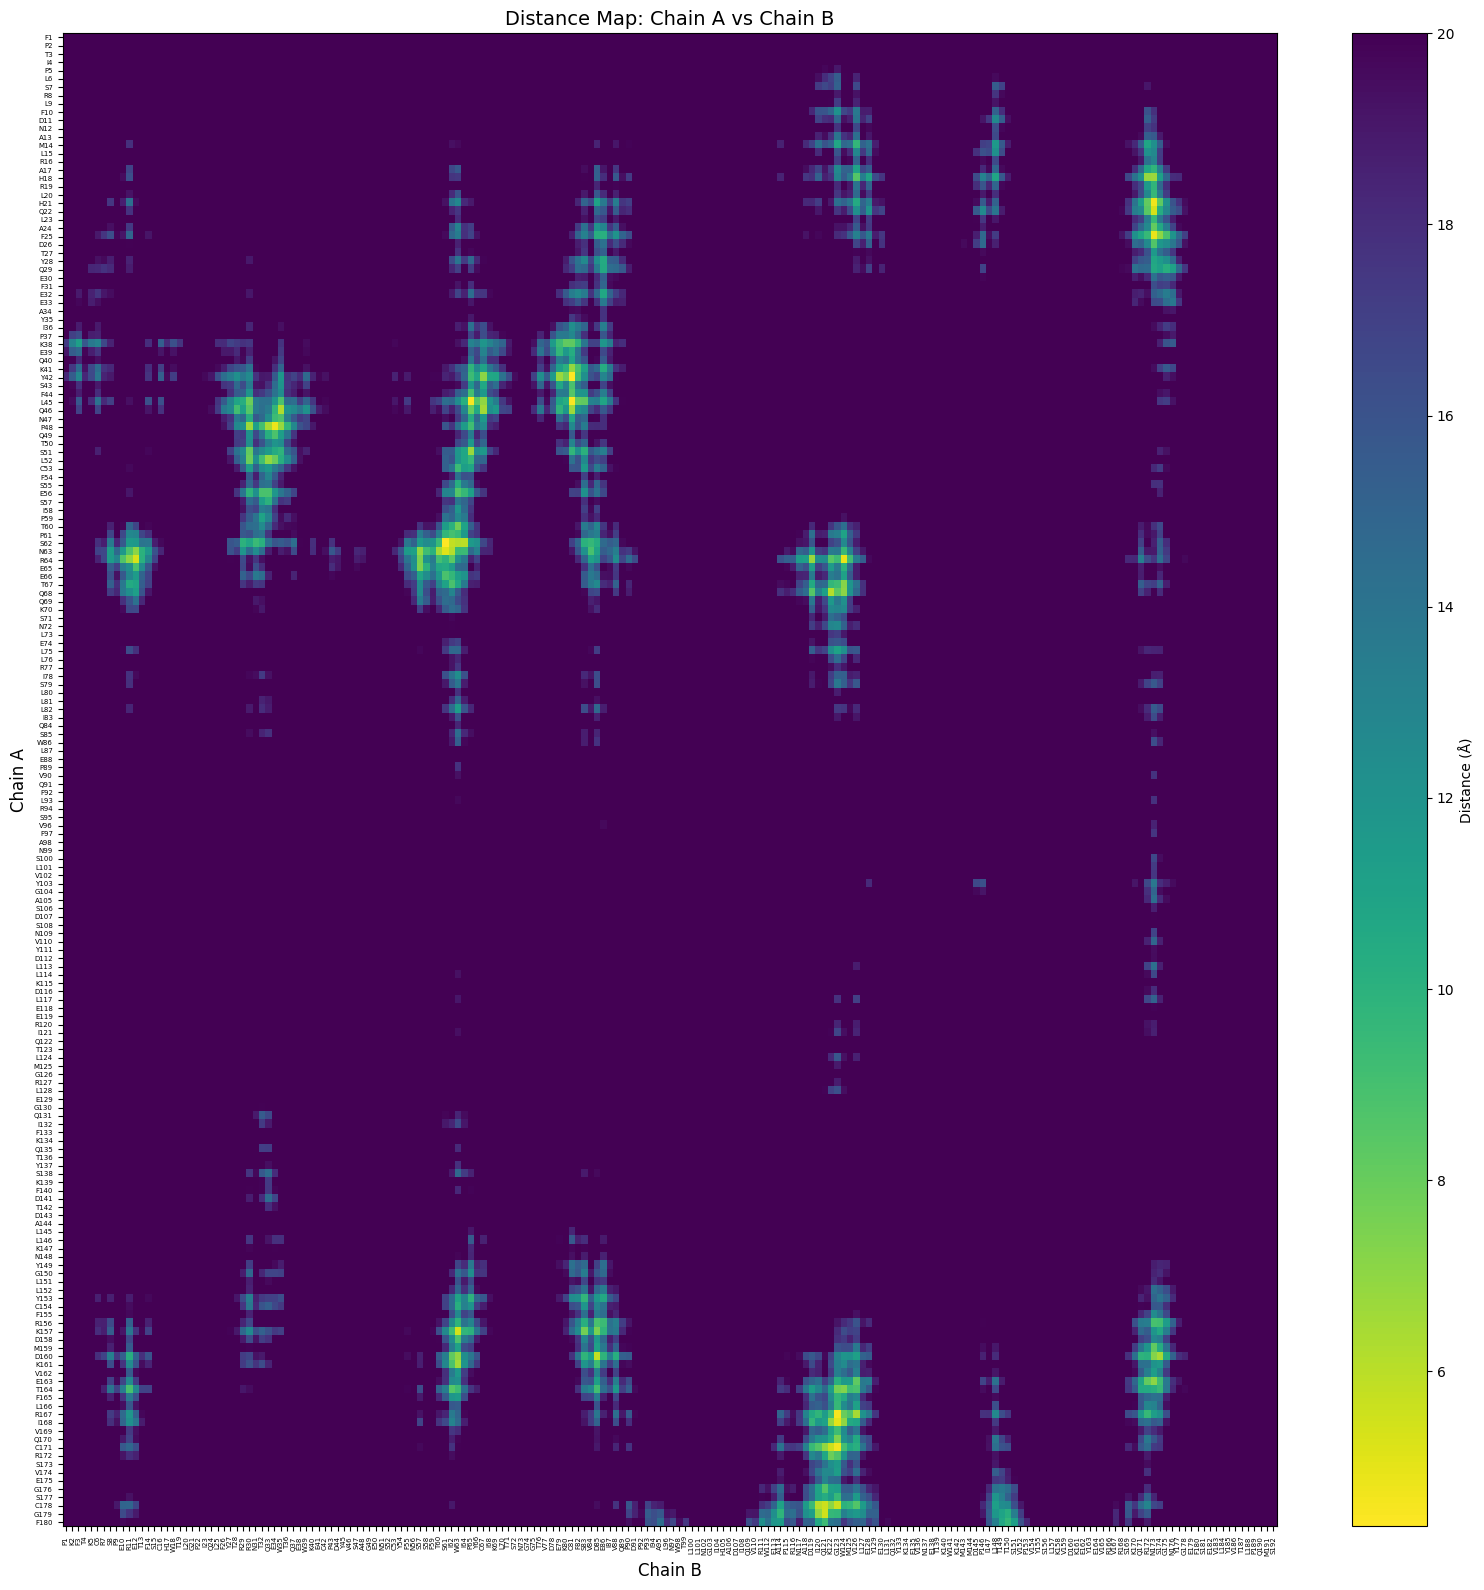

In [ ]:

from Bio.SeqUtils import seq1

# based on this we can create a contact map of the interface between chain A and chain B to vizualise contacts as a grid

residues_A = [res for res in structure[0]['A'].get_residues() if res.get_resname() != 'HOH']
residues_B = [res for res in structure[0]['B'].get_residues() if res.get_resname() != 'HOH']

# define a matrix to store distances
distance_map = np.zeros((len(residues_A), len(residues_B)))

# calculate distance 
# we want to see if the side chains are close, so we use the beta carbon (special case glycine where we have no beta, we use alpha)
for i, resA in enumerate(residues_A):
    for j, resB in enumerate(residues_B):
        if resA.has_id('CB'):
            cb_A = resA['CB'].get_coord()
        else:
            cb_A = resA['CA'].get_coord()
        if resB.has_id('CB'):
            cb_B = resB['CB'].get_coord()
        else:
            cb_B = resB['CA'].get_coord()
        distance = np.linalg.norm(cb_A - cb_B)
        distance_map[i, j] = distance

# plotting
# axis labels with 1-letter amino acid code + position
y_labels = [f"{seq1(res.get_resname())}{res.id[1]}" for res in residues_A]
x_labels = [f"{seq1(res.get_resname())}{res.id[1]}" for res in residues_B]
# step is how many residues to skip for axis labels
step = 1

plt.figure(figsize=(16, 16))
plt.imshow(distance_map, interpolation='nearest', aspect='auto', cmap='viridis_r', vmax=20)
plt.colorbar(label='Distance (Å)')
plt.xlabel('Chain B', fontsize=12)
plt.ylabel('Chain A', fontsize=12)
plt.title('Distance Map: Chain A vs Chain B', fontsize=14)

plt.yticks(range(0, len(residues_A), step), [y_labels[i] for i in range(0, len(residues_A), step)], fontsize=5)
plt.xticks(range(0, len(residues_B), step), [x_labels[i] for i in range(0, len(residues_B), step)], rotation=90, fontsize=5)
plt.tight_layout()
plt.show()


As you can see, we have a regions that are closer to the other chain. 

We can define some threshold to say if a sidechain is interacting or not based on this, let's say 8Å 

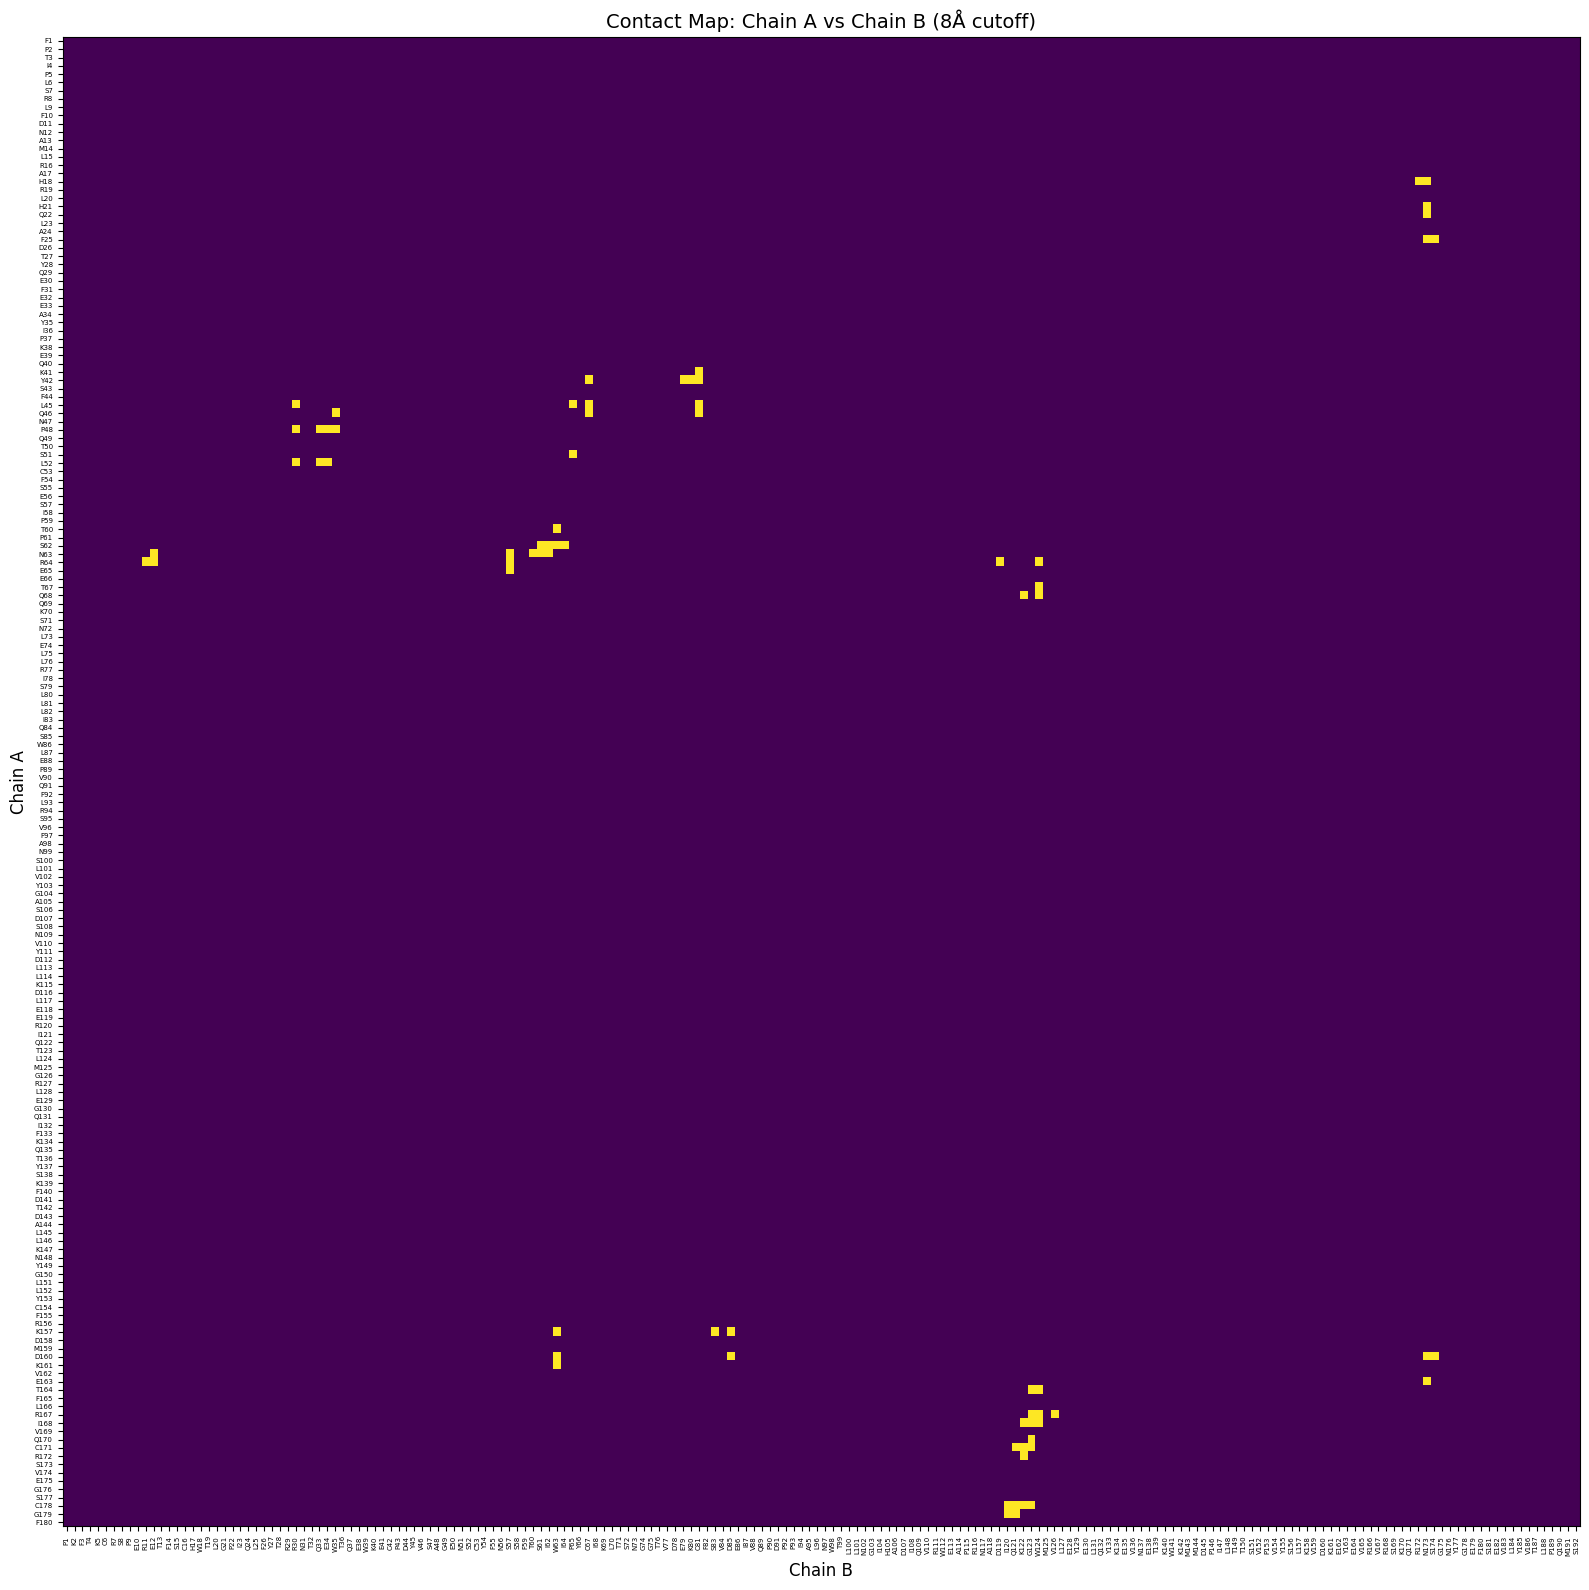

In [85]:

# first we define a empty matrix that will serve as our contact map
contact_map = np.zeros((len(residues_A), len(residues_B)))

# calculate distance 
for i, resA in enumerate(residues_A):
    for j, resB in enumerate(residues_B):
        if resA.has_id('CB'):
            cb_A = resA['CB'].get_coord()
        else:
            cb_A = resA['CA'].get_coord()
        
        if resB.has_id('CB'):
            cb_B = resB['CB'].get_coord()
        else:
            cb_B = resB['CA'].get_coord()
        distance = np.linalg.norm(cb_A - cb_B)
        if distance < 8.0:
            contact_map[i, j] = 1




plt.figure(figsize=(16, 16))
plt.imshow(contact_map, interpolation='nearest', aspect='auto')
plt.xlabel('Chain B', fontsize=12)
plt.ylabel('Chain A', fontsize=12)
plt.title('Contact Map: Chain A vs Chain B (8Å cutoff)', fontsize=14)


step = 1
plt.yticks(range(0, len(residues_A), step), [y_labels[i] for i in range(0, len(residues_A), step)], fontsize=5)
plt.xticks(range(0, len(residues_B), step), [x_labels[i] for i in range(0, len(residues_B), step)], rotation=90, fontsize=5)
plt.tight_layout()
plt.show()

## RDkit
Lets step away from Biopython for a minute and explore what we can do with RDkit. 


In [97]:
res1, res2

(<Residue PHE het=  resseq=1 icode= >, <Residue PRO het=  resseq=1 icode= >)

Before we use it let's introduce Simplified Molecular Input Line Entry Specification (SMILES). 
It is a way to represent the chemical molecules as a string. 
Since RDkit needs SMILES as an input we need to convert the amino acid string to a SMILES string 

In [98]:
def aa_to_smiles(aa):
    aa_smiles = {'ALA': 'C[C@H](N)C=O', 'CYS': 'N[C@H](C=O)CS', 'ASP': 'N[C@H](C=O)CC(=O)O', 'GLU': 'N[C@H](C=O)CCC(=O)O', 
                 'PHE': 'N[C@H](C=O)Cc1ccccc1', 'GLY': 'NCC=O', 
                 'HIS': 'N[C@H](C=O)Cc1c[nH]cn1','HID': 'N[C@H](C=O)Cc1c[nH]cn1','HIE': 'N[C@H](C=O)Cc1c[nH]cn1', 'HIP': 'N[C@H](C=O)Cc1c[nH]cn1',
                 'ILE': 'CC[C@H](C)[C@H](N)C=O', 'LYS': 'NCCCC[C@H](N)C=O', 'LEU': 'CC(C)C[C@H](N)C=O', 'MET': 'CSCC[C@H](N)C=O', 
                 'ASN': 'NC(=O)C[C@H](N)C=O', 'PRO': 'O=C[C@@H]1CCCN1', 'GLN': 'NC(=O)CC[C@H](N)C=O', 'ARG': 'N=C(N)NCCC[C@H](N)C=O', 
                 'SER': 'N[C@H](C=O)CO', 'THR': 'C[C@@H](O)[C@H](N)C=O', 'VAL': 'CC(C)[C@H](N)C=O', 
                 'TRP': 'N[C@H](C=O)Cc1c[nH]c2ccccc12','TYR': 'N[C@H](C=O)Cc1ccc(O)cc1'}
    return aa_smiles[aa]

In [99]:
res1_smiles = aa_to_smiles(res1.get_resname())
res2_smiles = aa_to_smiles(res2.get_resname())

In [100]:
res1_smiles

'N[C@H](C=O)Cc1ccccc1'

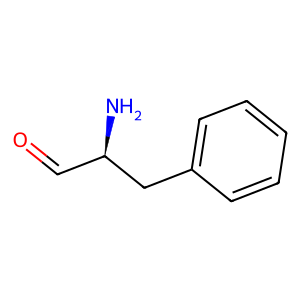

In [110]:
# lets draw it using RDkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
mol1 = Chem.MolFromSmiles(res1_smiles)
mol2 = Chem.MolFromSmiles(res2_smiles)


Draw.MolToImage(mol1)

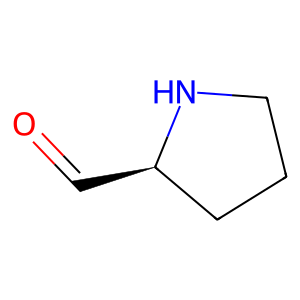

In [111]:
Draw.MolToImage(mol2)

In [114]:
# we can also use it to calculate some molecular properties such as molecular weight, logP, aromatic rings etc.
# there are all different kinds of descriptors availible in RDkit that you can explore so to find all of them check the RDkit documentation
from rdkit.Chem import Descriptors

wt1 = Descriptors.MolWt(mol1)
logp1 = Descriptors.MolLogP(mol1)
n_rings = Descriptors.RingCount(mol1)
wt1, logp1, n_rings

# using a combination of Biopython and RDkit we can start to extract features from the protein-protein interfaces.
# we can then use these features to train machine learning models to predict binding affinities.
# as this was only an intro, feel free to explore both Biopython and RDkit further on your own, and go to the ML notebook for general guidance on model building.

(149.19299999999998, 0.7552999999999994, 1)